# Voice AI Agent with Qwen2.5

In [1]:
## install Import necessary library
import cv2
import os 
import sys
import re
import time
import json
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI
from yolov8.yolov8 import YOLOv8
from yolov8.utils import class_names

## Init camera and YOLOv8 

In [ ]:
# Init camera
video_cap = cv2.VideoCapture(0)
video_cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
video_cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Create an inference session using the Vitis AI execution provider
input_model_file = r"onnx_utils\DetectionModel_int.onnx"
config_file_path = r"onnx_utils\vaip_config.json"
model = YOLOv8(input_model_file, config_file_path, 0.25) # probability threshold: 0.25. Notes: high probability threshold will casue the model failing in detecting object.


## Detection and save picture

(720, 720, 3)


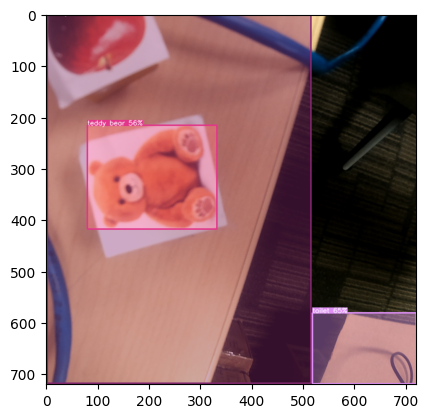

In [12]:
# capture one image

success, frame = video_cap.read()
frame = frame[:, 280:-280, ::-1]

print(frame.shape)
plt.imshow(frame)
plt.imsave('temp\out.jpg', frame)

ret = model.detect_objects(frame[:, :, ::-1])
detected_img = model.draw_detections(frame)
plt.imshow(detected_img)
plt.imsave('temp\\result.jpg', detected_img)

## Parse result

In [13]:
# parse label
def parse_ret(ret, origin_img):
    parsed_data = []

    for i in range(len(ret[0])):
        
        object = {   
        class_names[ret[2][i]],
        }
        #parsed_img["ThisIsSearchIndex_"+str(i)] = origin_img[y1:y2, x1:x2, :]
        parsed_data.append(object)
    return parsed_data


parsed_result = parse_ret(ret, frame[:, :, ::1])
print(parsed_result)

[{'dining table'}, {'toilet'}, {'teddy bear'}]


## ENTER YOUR QUERY HERE

In [14]:
query = "请给我讲个故事?"

### This our enhanced prompt here. 
This prompt is aimed at link the objects in image with the detection results from yolov8 so that the model can ground target object precisely.

In [21]:

prompt_1 = f"""
你是一个非常善于讲故事的AI Agent

你讲故事面向的群体是一群什么都不懂的美国小孩子。

我将会提供给不定数量的关键词，你需要将这几个关键词串联成一个有趣的故事讲给这群小孩子。

关键词形式如下：[{'person'}, {'tv'}, {'cell phone'}]  所以''中的词为关键词。

关键词如下：{parsed_result}

请注意：关键词的数量是随机提供给的。


"""
prompt_2 = f"""

用户询问: {query}. 你必须根据询问返回一个结果.

你不需要告诉我你是怎么设计的故事，也不需要在文本中有任何说明。给我一个完整的故事就行。

你的返回形式是这样的：
kwywords：关键词1 关键词2 ...... +  完整的故事。

请注意：一定要使用到所有给出的关键词并串联成一个有趣的故事。

请记住：生成内容的单词数在150-200之间。

小朋友听不懂中文。


"""
prompt = prompt_1 + prompt_2

In [ ]:
# #
# prompt_1 = f"""
# You are an AI agent who is very good at telling stories

# The group you are telling stories to is a group of American children who don't understand anything.

# I will provide an indefinite number of keywords, and you need to string these keywords together to tell an interesting story to this group of children.

# The keyword forms are as follows: [{'person '}, {'tv'}, {'cell phone '}], so the words in' 'are keywords.

# The keywords are as follows: {parsed_result}

# Please note that the number of keywords is randomly provided.

# """
# prompt_2 = f"""
# User inquiry: {query} You must return a result based on the inquiry

# You don't need to tell me how you designed the story, nor do you need any explanation in the text. Just give me a complete story.

# Your return form is as follows:
# Kwywords: Keyword 1 Keyword 2+ The complete story.

# Please note: Be sure to use all the given keywords and connect them together to form an interesting story.

# Please remember: no less than 250 words.

# Children cannot understand Chinese.

# Please note: Finally, please provide me with a return in English story text format.

# """
# prompt = prompt_1 + prompt_2

## Call LLM to reason


In [26]:

client = OpenAI(base_url="http://127.0.0.1:1234/v1", api_key="")
messages = []
first_turn = {
            "role": "user",
            "content": [
                {
                "type": "text",
                "text": f"{prompt}",
                }
            ]
        }
messages.append(first_turn)
payload = {
    "model": "qwen2.5-7b-instruct",
    "messages": f"{json.dumps(messages, indent=4)}",
}
response = requests.post("http://127.0.0.1:1234/v1/chat/completions", json=payload)
print(response)
response.json()

<Response [200]>


{'id': 'chatcmpl-9n5n67wo0k837eodmbze7',
 'object': 'chat.completion',
 'created': 1732254953,
 'model': 'qwen2.5-7b-instruct',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': "Keywords: dining table, toilet, teddy bear\n\nOnce upon a time, in a cozy little house lived a happy family. Every day, the daddy would come back home from work and sit at the dining table to have dinner with his family. One evening, while eating their meal, the family noticed something funny - their teddy bear was sitting on the toilet! It wasn't moving or making any noise. The mommy thought it was just playing a trick, but when she checked, the teddy bear suddenly jumped off and ran towards the dining table.\n\nThe whole family laughed out loud at this unexpected surprise. They wondered how the teddy could get from the toilet to the table. Later that night, they found out it was the cell phone's fault! The daddy had left his cell phone on the floor near the toilet earlier in the da

In [27]:
content = str(response.json()['choices'][0]['message']['content'])
print(content)

Keywords: dining table, toilet, teddy bear

Once upon a time, in a cozy little house lived a happy family. Every day, the daddy would come back home from work and sit at the dining table to have dinner with his family. One evening, while eating their meal, the family noticed something funny - their teddy bear was sitting on the toilet! It wasn't moving or making any noise. The mommy thought it was just playing a trick, but when she checked, the teddy bear suddenly jumped off and ran towards the dining table.

The whole family laughed out loud at this unexpected surprise. They wondered how the teddy could get from the toilet to the table. Later that night, they found out it was the cell phone's fault! The daddy had left his cell phone on the floor near the toilet earlier in the day, and somehow, the teddy bear must have used the cell phone as a bridge or a ladder to reach the dining table.

From then on, everyone became more careful around the house, especially where their little teddy 

# Trans to voice playback


In [28]:
import pyttsx3
import threading
def generate_speech(content):
    engine = pyttsx3.init()
    engine.say(content)
    engine.runAndWait()



In [29]:
thread = threading.Thread(target=generate_speech,args=(content, ))
thread.start()
thread.join()